# **Implémentation d'un modèle de scoring**
## **Notebook 3/6 - Modélisation : Choix de l'algorithme & Stratégie de rééquilibrage**
*Sofia Chevrolat (Novembre 2020)*
___
Cette étude vise à réaliser un modèle permettant de prédire le risque de défaut de remboursement d'un prêt pour un client donné. Ce modèle doit être basé sur une variété de données (personnelles, en provenance de différentes sources bancaires, etc.).

Ce modèle est destiné à être servi via une API, elle-même appelée via un dashboard interactif. Le modèle devra donc être exporté une fois finalisé.
___
_**Remerciements**:<br>
Merci à mon compagnon [J. Duplan](https://www.linkedin.com/in/julian-duplan-64844a41/) pour les discussions intéressantes.<br>
Merci également à mon mentor [Samia Drappeau](https://www.linkedin.com/in/samiadrappeau) pour les échanges d'idées, les conseils et les encouragements !_
___


Ce notebook est organisé comme suit:

**0. Mise en place**
- 0.1 Chargement des librairies et fonctions utiles
- 0.2 Chargement et description du jeu de données
- 0.3 Suppression des features non pertinentes
- 0.4 Sampling
- 0.5 Séparation des données
    
**1. Création métrique - fonction de coût propres**

**2. Preprocessing**
- 2.1 Imputation des valeurs manquantes
- 2.2 Mise à l'échelle
- 2.3 Rééquilibrage des classes
    * 2.3.1 Undersampling
    * 2.3.2 Oversampling

**3. Choix de l'algorithme**
- 3.1 Baseline : Dummy Classifier
    * 3.1.1 Stratégie de rééquilibrage : aucune
    * 3.1.2 Stratégie de rééquilibrage : undersampling
    * 3.1.3 Stratégie de rééquilibrage : oversampling
    * 3.1.4 Stratégie de rééquilibrage : class_weight = "balanced"
- 3.2 Régression Logistique
    * 3.2.1 Stratégie de rééquilibrage : aucune
    * 3.2.2 Stratégie de rééquilibrage : undersampling
    * 3.2.3 Stratégie de rééquilibrage : oversampling
    * 3.2.4 Stratégie de rééquilibrage : class_weight = "balanced"
- 3.3 Random Forest Classifier
    * 3.3.1 Stratégie de rééquilibrage : aucune
    * 3.3.2 Stratégie de rééquilibrage : undersampling
    * 3.3.3 Stratégie de rééquilibrage : oversampling
    * 3.3.4 Stratégie de rééquilibrage : class_weight = "balanced"
- 3.4 Light Gradient Boosting Machine
    * 3.4.1 Stratégie de rééquilibrage : aucune
    * 3.4.2 Stratégie de rééquilibrage : undersampling
    * 3.4.3 Stratégie de rééquilibrage : oversampling
    * 3.4.4 Stratégie de rééquilibrage : class_weight = "balanced"
- 3.5 Comparaison des performances

**4. Conclusion**

___
### 0. MISE EN PLACE

Dans cette première étape, le cadre de travail est mis en place, c'est-à-dire :
- Les librairies et packages Python nécessaires sont chargés
- Les fonctions utiles sont définies
- Le jeu de données est chargé
___

___
#### 0.1 CHARGEMENT DES LIBRAIRIES ET FONCTIONS UTILES

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import pandas as pd
import numpy as np
import re
from unidecode import unidecode
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import time
import random
import gc

In [3]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold

In [4]:
from sys import path
path.append("./Resources/functions")

import helper_functions as hf
import graphical_functions as gf

___
#### 0.2 CHARGEMENT DES DONNÉES

In [5]:
data = pd.read_csv("./Resources/datasets/assembled/full_training_data.csv")

___
#### 0.3 SUPPRESSION DES FEATURES NON PERTINENTES

Nous allons supprimer la colonne indiquant l'ID du client.

De plus, afin d'éviter de perpétuer des biais, nous allons supprimer la colonne ayant trait au sexe des clients.

In [6]:
cols_to_drop = ["SK_ID_CURR", "CODE_GENDER_M", "CODE_GENDER_F", "CODE_GENDER_XNA"]
data_model = data.drop(columns=cols_to_drop)

___
#### 0.4 SAMPLING DES DONNÉES

Le jeu de données étant relativement important, nous allons dans un premier temps utiliser un sampling des données.

In [7]:
# Sampling
data_sample = data_model.sample(100000, random_state=42)

___
#### 0.5 SÉPARATION DES DONNÉES

Le jeu de données va être séparé entre données d'entraînement et données de test.

L'analyse exploratoire ayant fait ressortir un important déséquilibre des classes dans TARGET, nous devons veiller à maintenir ces proportions dans nos nouveaux jeux.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data_sample.drop(columns=["TARGET"]), 
                                                    data_sample["TARGET"], 
                                                    train_size=0.8, random_state=42, 
                                                    stratify=data_sample["TARGET"])

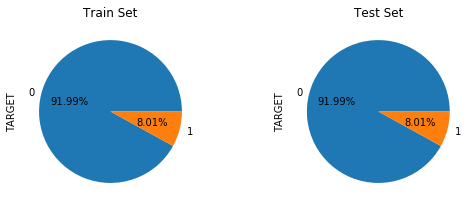

In [9]:
# Display proportion of target value in both train and eval set
fig, ax = plt.subplots(1,2, figsize=(8,4))
y_train.value_counts().plot.pie(autopct='%1.2f%%', ax=ax[0], title='Train Set')
y_test.value_counts().plot.pie(autopct='%1.2f%%', ax=ax[1], title='Test Set')
fig.subplots_adjust(wspace=0.5)

___
### 1. CRÉATION MÉTRIQUE - FONCTION DE COÛT PROPRES

Dans notre cas, il est important de pénaliser les faux positifs bien plus que les faux négatifs. 

Nous allons donc créer une fonction de coût - métrique spécifique à notre problème de classification qui doit permettre de minimiser le risque pour la banque.
___

In [10]:
def bank_score(y_true, y_pred):
    
    (TN, FP, FN, TP) = confusion_matrix(y_true, y_pred).ravel()
    N = TN + FP    # total negatives cases
    P = TP + FN    # total positives cases
    
    # We set the bank's gain and loss for each case
    FN_value = -10   # The loan is granted but the customer defaults (Type-II Error) 
    TN_value = 1     # The loan is reimbursed
    TP_value = 0     # The loan is (rightly) refused
    FP_value = -1    # Loan is refused by mistake (Type-I Error)

    # calculate total gains
    gain = TP*TP_value + TN*TN_value + FP*FP_value + FN*FN_value
    
    # best score : all observations are correctly predicted
    best = N*TN_value + P*TP_value 

    # baseline : all observations are predicted = 0
    baseline = N*TN_value + P*FN_value 
    
    # normalize to get score between 0 (baseline) and 1
    score = (gain - baseline) / (best - baseline)
    
    return score

In [11]:
custom_score = make_scorer(bank_score)

Ce score est caractérisé par les valeurs significatives suivantes:
- une baseline à 0 dans le cas où le modèle donne une prédiction à 0 (classe majoritaire) pour toutes les observations.
- une valeur maximale de 1 dans le cas où le modèle donne une prédiction correcte pour toutes les observations.

___
### 2. PRÉPROCESSING

L'analyse exploratoire a permis de mettre en lumière :
- Un certain nombre de valeurs manquantes
- Le caractère déséquilibré du jeu de données : 91,68% des prêts ont été remboursés, contre seulement 8,33% de prêts non remboursés dans le jeu de données.

    3 approches sont possibles dans ce cas :
    - Undersampling : supprimer des observations de la classe majoritaire afin de rééquilibrer le jeu
    - Oversampling : répéter des observations de la classe minoritaire afin de rééquilibrer le jeu
    - weight_balanced : indiquer au modèle le déséquilibre afin qu'il en tienne compte directement

    Nous allons utiliser ces 3 approches et comparer les résultats pour l'ensemble des modèles.

___
#### 2.1. IMPUTATION DES VALEURS MANQUANTES


In [12]:
# Median imputation of missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

In [13]:
# Fit on the training data
imputer.fit(X_train)

SimpleImputer(strategy='median')

In [14]:
# Transform training data
X_train_preproc = imputer.transform(X_train)
X_test_preproc = imputer.transform(X_test)

___
#### 2.2 MISE À L'ÉCHELLE DES VALEURS


In [15]:
# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

In [16]:
# Repeat with the scaler
scaler.fit(X_train_preproc)
X_train_preproc = scaler.transform(X_train_preproc)
X_test_preproc = scaler.transform(X_test_preproc)

In [17]:
xtrain = pd.DataFrame(scaler.transform(X_train_preproc), 
                      index=X_train.index, 
                      columns=X_train.columns)

xtest = pd.DataFrame(scaler.transform(X_test_preproc), 
                     index=X_test.index, 
                     columns=X_test.columns)

___
#### 2.3 STRATÉGIE DE RÉÉQUILIBRAGE


##### 2.3.1 _<u>Undersampling</u>_

In [18]:
rus = RandomUnderSampler(random_state=6)

###### **The standard dataset**

In [19]:
xtrain_us_std, ytrain_us_std = rus.fit_resample(X_train, y_train)

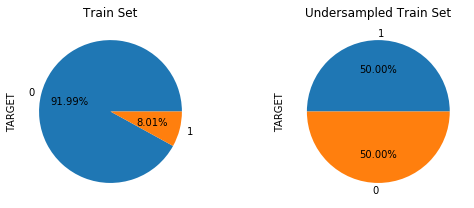

In [20]:
# Display proportion of target value in both train and eval set
fig, ax = plt.subplots(1,2, figsize=(8,4))
y_train.value_counts().plot.pie(autopct='%1.2f%%', ax=ax[0], title='Train Set')
ytrain_us_std.value_counts().plot.pie(autopct='%1.2f%%', ax=ax[1], title='Undersampled Train Set')
fig.subplots_adjust(wspace=0.5)

###### **The imputed and scaled dataset**

In [21]:
xtrain_us, ytrain_us = rus.fit_resample(xtrain, y_train)

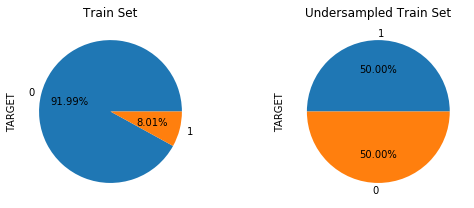

In [22]:
# Display proportion of target value in both train and eval set
fig, ax = plt.subplots(1,2, figsize=(8,4))
y_train.value_counts().plot.pie(autopct='%1.2f%%', ax=ax[0], title='Train Set')
ytrain_us.value_counts().plot.pie(autopct='%1.2f%%', ax=ax[1], title='Undersampled Train Set')
fig.subplots_adjust(wspace=0.5)

Le jeu de données undersampled est parfaitement équilibré.

In [23]:
print("Le jeu de données undersampled contient {} observations, c'est-à-dire {} de moins que le jeu de données standard, soit {:1.2f}% de moins."\
      .format(len(ytrain_us), len(y_train)-len(ytrain_us), (len(y_train)-len(ytrain_us))/len(y_train)*100))

Le jeu de données undersampled contient 12816 observations, c'est-à-dire 67184 de moins que le jeu de données standard, soit 83.98% de moins.


##### 2.3.2 _<u>Oversampling</u>_

###### **The standard dataset**

The standard dataset can not be oversampled since it contains missing values.

###### **The imputed + scaled dataset**

In [24]:
smote = SMOTE(random_state=6)
xtrain_os, ytrain_os = smote.fit_resample(xtrain, y_train)

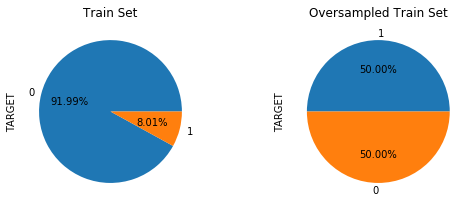

In [25]:
# Display proportion of target value in both train and eval set
fig, ax = plt.subplots(1,2, figsize=(8,4))
y_train.value_counts().plot.pie(autopct='%1.2f%%', ax=ax[0], title='Train Set')
ytrain_os.value_counts().plot.pie(autopct='%1.2f%%', ax=ax[1], title='Oversampled Train Set')
fig.subplots_adjust(wspace=0.5)

Le jeu de données oversampled est parfaitement équilibré.

___
### 3. CHOIX DE L'ALGORITHME
Afin de modéliser au mieux notre problème, nous allons comparer les performances de trois algorithmes : 
- Régression Logistique
- RandomForestClassifier
- Light Gradient Boosting

Leurs performances seront comparées à celles d'une baseline naïve, un DummyClassifier.

In [26]:
results = pd.DataFrame(columns=["Algorithm", "Balancing Method",
                                "ROC AUC score", "ROC AUC score Test",
                                "Custom score", "Custom score test"])

___
#### 3.1 BASELINE : DUMMY CLASSIFIER

##### _<u>3.1.1 Stratégie de rééquilibrage : aucune</u>_

In [27]:
bank_scores, bank_scores_test, roc_auc_scores, roc_auc_scores_test = hf.cv_score_sample(DummyClassifier(strategy="most_frequent"), 
                                                                                        xtrain, 
                                                                                        y_train, 
                                                                                        xtest,
                                                                                        y_test,
                                                                                        bank_score)

In [28]:
row = ["Baseline", 
       "None",
       roc_auc_scores.mean(), 
       roc_auc_scores_test,
       bank_scores.mean(),
       bank_scores_test]

results.loc[len(results)] = row

##### _<u>3.1.2 Stratégie de rééquilibrage : undersampling</u>_

In [29]:
bank_scores, bank_scores_test, \
roc_auc_scores, roc_auc_scores_test = hf.cv_score_sample(DummyClassifier(strategy="most_frequent"), 
                                                         xtrain_us, 
                                                         ytrain_us, 
                                                         xtest,
                                                         y_test, 
                                                         bank_score)

In [30]:
row = ["Baseline", 
       "Undersampling",
       roc_auc_scores.mean(), 
       roc_auc_scores_test,
       bank_scores.mean(),
       bank_scores_test]

results.loc[len(results)] = row

##### 3.1.3 _<u>Stratégie de rééquilibrage : oversampling</u>_

In [31]:
bank_scores, bank_scores_test, \
roc_auc_scores, roc_auc_scores_test = hf.cv_score_sample(DummyClassifier(strategy="most_frequent"), 
                                                         xtrain_os, 
                                                         ytrain_os,  
                                                         xtest,
                                                         y_test,
                                                         bank_score)

In [32]:
row = ["Baseline", 
       "Oversampling",
       roc_auc_scores.mean(), 
       roc_auc_scores_test,
       bank_scores.mean(),
       bank_scores_test]

results.loc[len(results)] = row

##### _<u>3.1.4 Stratégie de rééquilibrage : class_weight="balanced"</u>_

Ce paramètre n'existant pas explicitement pour le Dummy Classifier, nous allons simuler son utilisation en modifiant la stratégie en "stratified". Le Dummy Classifier va ainsi générer des prédictions en fonction de la distribution de la valeur à prédire.

In [33]:
bank_scores, bank_scores_test, \
roc_auc_scores, roc_auc_scores_test = hf.cv_score_sample(DummyClassifier(strategy="stratified"), 
                                                         xtrain, 
                                                         y_train,  
                                                         xtest,
                                                         y_test,
                                                         bank_score)

In [34]:
row = ["Baseline", 
       "Balanced",
       roc_auc_scores.mean(), 
       roc_auc_scores_test,
       bank_scores.mean(),
       bank_scores_test]

results.loc[len(results)] = row

In [35]:
results

,Algorithm,Balancing Method,ROC AUC score,ROC AUC score Test,Custom score,Custom score test
0,Baseline,None,0.500,0.500,0.000,0.000
1,Baseline,Undersampling,0.500,0.500,0.320,0.000
2,Baseline,Oversampling,0.500,0.500,0.320,0.000
3,Baseline,Balanced,0.501,0.501,-0.103,-0.105


___
#### 3.2 RÉGRESSION LOGISTIQUE

In [36]:
# Make the model with the specified regularization parameter
LR = LogisticRegression(C = 0.0001)
LR_balanced = LogisticRegression(C=0.0001, class_weight="balanced")

##### _<u>3.2.1 Stratégie de rééquilibrage : aucune</u>_

In [37]:
bank_scores, bank_scores_test, \
roc_auc_scores, roc_auc_scores_test = hf.cv_score_sample(LR, 
                                                         xtrain, 
                                                         y_train,  
                                                         xtest,
                                                         y_test,
                                                         bank_score)

In [38]:
row = ["LR", 
       "None",
       roc_auc_scores.mean(), 
       roc_auc_scores_test,
       bank_scores.mean(),
       bank_scores_test]

results.loc[len(results)] = row

##### _<u>3.2.2 Stratégie de rééquilibrage : undersampling</u>_

In [39]:
bank_scores, bank_scores_test, \
roc_auc_scores, roc_auc_scores_test = hf.cv_score_sample(LR, 
                                                         xtrain_us, 
                                                         ytrain_us,  
                                                         xtest,
                                                         y_test,
                                                         bank_score)

In [40]:
row = ["LR", 
       "Undersampling",
       roc_auc_scores.mean(), 
       roc_auc_scores_test,
       bank_scores.mean(),
       bank_scores_test]

results.loc[len(results)] = row

##### _<u>3.2.3 Stratégie de rééquilibrage : oversampling</u>_

In [41]:
bbank_scores, bank_scores_test, \
roc_auc_scores, roc_auc_scores_test = hf.cv_score_sample(LR, 
                                                         xtrain_os, 
                                                         ytrain_os,  
                                                         xtest,
                                                         y_test,
                                                         bank_score)

In [42]:
row = ["LR", 
       "Oversampling",
       roc_auc_scores.mean(), 
       roc_auc_scores_test,
       bank_scores.mean(),
       bank_scores_test]

results.loc[len(results)] = row

##### _<u>3.2.4 Stratégie de rééquilibrage : class_weight='balanced'</u>_

In [43]:
bank_scores, bank_scores_test, \
roc_auc_scores, roc_auc_scores_test = hf.cv_score_sample(LR_balanced, 
                                                         xtrain, 
                                                         y_train,  
                                                         xtest,
                                                         y_test,
                                                         bank_score)

In [44]:
row = ["LR", 
       "Balanced",
       roc_auc_scores.mean(), 
       roc_auc_scores_test,
       bank_scores.mean(),
       bank_scores_test]

results.loc[len(results)] = row

In [45]:
results

,Algorithm,Balancing Method,ROC AUC score,ROC AUC score Test,Custom score,Custom score test
0,Baseline,None,0.5000,0.500,0.0000,0.000
1,Baseline,Undersampling,0.5000,0.500,0.3200,0.000
2,Baseline,Oversampling,0.5000,0.500,0.3200,0.000
3,Baseline,Balanced,0.5010,0.501,-0.1030,-0.105
4,LR,None,0.5000,0.500,0.0000,0.000
5,LR,Undersampling,0.5822,0.600,0.5410,-0.393
6,LR,Oversampling,0.6538,0.643,0.5410,-0.197
7,LR,Balanced,0.6252,0.635,-0.2712,-0.246


___
#### 3.3 RANDOM FOREST CLASSIFIER


In [46]:
# Make the random forest classifier
RF = RandomForestClassifier(n_estimators = 100, 
                            random_state = 42, 
                            verbose = 1, 
                            n_jobs = -1)

RF_balanced = RandomForestClassifier(n_estimators = 100, 
                                     random_state = 42, 
                                     verbose = 1, 
                                     n_jobs = -1, 
                                     class_weight="balanced")

##### _<u>3.3.1 Stratégie de rééquilibrage : aucune</u>_

In [47]:
bank_scores, bank_scores_test, \
roc_auc_scores, roc_auc_scores_test = hf.cv_score_sample(RF, 
                                                         xtrain, 
                                                         y_train,  
                                                         xtest,
                                                         y_test,
                                                         bank_score)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel

In [48]:
row = ["RF", 
       "None",
       roc_auc_scores.mean(), 
       roc_auc_scores_test,
       bank_scores.mean(),
       bank_scores_test]

results.loc[len(results)] = row

##### _<u>3.3.2 Stratégie de rééquilibrage : undersampling</u>_

In [49]:
bank_scores, bank_scores_test, \
roc_auc_scores, roc_auc_scores_test = hf.cv_score_sample(RF, 
                                                         xtrain_us, 
                                                         ytrain_us,  
                                                         xtest,
                                                         y_test,
                                                         bank_score)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel

In [50]:
row = ["RF", 
       "Undersampling",
       roc_auc_scores.mean(), 
       roc_auc_scores_test,
       bank_scores.mean(),
       bank_scores_test]

results.loc[len(results)] = row

##### _<u>3.3.3 Stratégie de rééquilibrage : oversampling</u>_

In [51]:
bank_scores, bank_scores_test, \
roc_auc_scores, roc_auc_scores_test = hf.cv_score_sample(RF, 
                                                         xtrain_os, 
                                                         ytrain_os,  
                                                         xtest,
                                                         y_test,
                                                         bank_score)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel

In [52]:
row = ["RF", 
       "Oversampling",
       roc_auc_scores.mean(), 
       roc_auc_scores_test,
       bank_scores.mean(),
       bank_scores_test]

results.loc[len(results)] = row

##### _<u>3.3.4 Stratégie de rééquilibrage : class_weight="balanced"</u>_

In [53]:
bank_scores, bank_scores_test, \
roc_auc_scores, roc_auc_scores_test = hf.cv_score_sample(RF_balanced, 
                                                         xtrain, 
                                                         y_train,  
                                                         xtest,
                                                         y_test,
                                                         bank_score)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel

In [54]:
row = ["RF", 
       "Balanced",
       roc_auc_scores.mean(), 
       roc_auc_scores_test,
       bank_scores.mean(),
       bank_scores_test]

results.loc[len(results)] = row

In [55]:
results

,Algorithm,Balancing Method,ROC AUC score,ROC AUC score Test,Custom score,Custom score test
0,Baseline,None,0.5000,0.500,0.0000,0.000
1,Baseline,Undersampling,0.5000,0.500,0.3200,0.000
2,Baseline,Oversampling,0.5000,0.500,0.3200,0.000
3,Baseline,Balanced,0.5010,0.501,-0.1030,-0.105
4,LR,None,0.5000,0.500,0.0000,0.000
5,LR,Undersampling,0.5822,0.600,0.5410,-0.393
6,LR,Oversampling,0.6538,0.643,0.5410,-0.197
7,LR,Balanced,0.6252,0.635,-0.2712,-0.246
8,RF,None,0.5004,0.500,0.0008,-0.000
9,RF,Undersampling,0.6676,0.670,0.5870,-0.072


___
#### 3.4 LIGHT GRADIENT BOOSTING MACHINE


Le modèle Light Gradient Boosting Machine fonctionne avec des valeurs manquantes et est invariant à l'échelle. Les données sans preprocessing peuvent donc être utilisées.

In [56]:
X_train_model = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
xtrain_us_std_model = xtrain_us_std.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [57]:
X_test_model = X_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [58]:
# Create the model
lgbm_model = lgb.LGBMClassifier(n_estimators=10000, 
                                objective = 'binary', 
                                learning_rate = 0.05, 
                                reg_alpha = 0.1, 
                                reg_lambda = 0.1, 
                                subsample = 0.8, n_jobs = -1, 
                                random_state = 42)

lgbm_model_balanced = lgb.LGBMClassifier(n_estimators=10000, 
                                         objective = 'binary', 
                                         class_weight = 'balanced', 
                                         learning_rate = 0.05, 
                                         reg_alpha = 0.1, 
                                         reg_lambda = 0.1, 
                                         subsample = 0.8, 
                                         n_jobs = -1, 
                                         random_state = 42)


##### _<u>3.4.1 Stratégie de rééquilibrage : aucune</u>_

In [59]:
bank_scores, bank_scores_test, \
roc_auc_scores, roc_auc_scores_test = hf.cv_score_sample(lgbm_model, 
                                                         X_train_model, 
                                                         y_train,  
                                                         X_test_model,
                                                         y_test,
                                                         bank_score, 
                                                         5, 
                                                         loss_func="roc_auc")

In [60]:
row = ["LGBM - ROC AUC", 
       "None",
       roc_auc_scores.mean(), 
       roc_auc_scores_test,
       bank_scores.mean(),
       bank_scores_test]

results.loc[len(results)] = row

In [61]:
bank_scores, bank_scores_test, \
roc_auc_scores, roc_auc_scores_test = hf.cv_score_sample(lgbm_model, 
                                                         X_train_model, 
                                                         y_train,  
                                                         X_test_model,
                                                         y_test,
                                                         bank_score, 
                                                         5, 
                                                         loss_func=custom_score)

In [62]:
row = ["LGBM - BANK SCORE", 
       "None",
       roc_auc_scores.mean(), 
       roc_auc_scores_test,
       bank_scores.mean(),
       bank_scores_test]

results.loc[len(results)] = row

##### _<u>3.4.2 Stratégie de rééquilibrage : undersampling</u>_

In [63]:
bank_scores, bank_scores_test, \
roc_auc_scores, roc_auc_scores_test = hf.cv_score_sample(lgbm_model, 
                                                         xtrain_us_std_model, 
                                                         ytrain_us_std, 
                                                         X_test_model,
                                                         y_test,
                                                         bank_score, 
                                                         5, 
                                                         loss_func="roc_auc")

In [64]:
row = ["LGBM - ROC AUC", 
       "Undersampling",
       roc_auc_scores.mean(), 
       roc_auc_scores_test,
       bank_scores.mean(),
       bank_scores_test]

results.loc[len(results)] = row

In [65]:
bank_scores, bank_scores_test, \
roc_auc_scores, roc_auc_scores_test = hf.cv_score_sample(lgbm_model, 
                                                         xtrain_us_std_model, 
                                                         ytrain_us_std, 
                                                         X_test_model,
                                                         y_test,
                                                         bank_score, 
                                                         5, 
                                                         loss_func=custom_score)

In [66]:
row = ["LGBM - BANK SCORE", 
       "Undersampling",
       roc_auc_scores.mean(), 
       roc_auc_scores_test,
       bank_scores.mean(),
       bank_scores_test]

results.loc[len(results)] = row

##### _<u>3.4.3 Stratégie de rééquilibrage : oversampling</u>_

Ce n'est pas possible pour un jeu de données contenant des données manquantes.

In [67]:
row = ["LGBM - ROC AUC", 
       "Oversampling",
       "NA",
       "NA",
       "NA", 
       "NA"]

results.loc[len(results)] = row

In [68]:
row = ["LGBM - CUSTOM SCORE", 
       "Oversampling",
       "NA",
       "NA",
       "NA", 
       "NA"]

results.loc[len(results)] = row

##### _<u>3.4.4 Stratégie de rééquilibrage : class_weight='balanced'</u>_

In [69]:
bank_scores, bank_scores_test, \
roc_auc_scores, roc_auc_scores_test = hf.cv_score_sample(lgbm_model_balanced, 
                                                         X_train_model, 
                                                         y_train,  
                                                         X_test_model,
                                                         y_test,
                                                         bank_score, 
                                                         5, 
                                                         loss_func="roc_auc")

In [70]:
row = ["LGBM - ROC AUC", 
       "Balanced",
       roc_auc_scores.mean(), 
       roc_auc_scores_test,
       bank_scores.mean(),
       bank_scores_test]

results.loc[len(results)] = row

In [71]:
bank_scores, bank_scores_test, \
roc_auc_scores, roc_auc_scores_test = hf.cv_score_sample(lgbm_model_balanced, 
                                                         X_train_model, 
                                                         y_train, 
                                                         X_test_model,
                                                         y_test, 
                                                         bank_score, 
                                                         5, 
                                                         loss_func=custom_score)

In [72]:
row = ["LGBM - BANK SCORE", 
       "Balanced",
       roc_auc_scores.mean(), 
       roc_auc_scores_test,
       bank_scores.mean(),
       bank_scores_test]

results.loc[len(results)] = row

___
#### 3.5 COMPARAISON DES PERFORMANCES

In [73]:
results

,Algorithm,Balancing Method,ROC AUC score,ROC AUC score Test,Custom score,Custom score test
0,Baseline,None,0.5,0.5,0,0
1,Baseline,Undersampling,0.5,0.5,0.32,0
2,Baseline,Oversampling,0.5,0.5,0.32,0
3,Baseline,Balanced,0.501,0.501,-0.103,-0.105
4,LR,None,0.5,0.5,0,0
5,LR,Undersampling,0.5822,0.6,0.541,-0.393
6,LR,Oversampling,0.6538,0.643,0.541,-0.197
7,LR,Balanced,0.6252,0.635,-0.2712,-0.246
8,RF,None,0.5004,0.5,0.0008,-0
9,RF,Undersampling,0.6676,0.67,0.587,-0.072


L'algorithme Light Gradient Boosting avec l'argument "balanced" donne les meilleurs résultats.
C'est donc avec celui-ci que nous poursuivrons.

___
### 4. CONCLUSION

___

L'algorithme Light Gradient Boosting Machine associé à la stratégie de rééquilibrage consistant à indiquer "balanced" comme valeur pour "weight_class" donne les meilleurs résultats sur notre jeu de données.

Pour terminer l'élaboration de notre modèle, deux étapes restent à effectuer :
- affiner la sélection des features : notre algorithme utilise actuellement plus de 1000 features, ce qui présente deux inconvénients :
  - des coûts en calcul élevés
  - certaines features ne contribuent peu ou pas au modèle, et peuvent même l'induire en erreur
- affiner les valeurs des hyperparamètres pour obtenir les meilleurs résultats possibles.